In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Parkinsson_disease.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [28]:
data['status'].value_counts()
#1 = Parkinson's, 0 = healthy

,count
status,
1,147
0,48


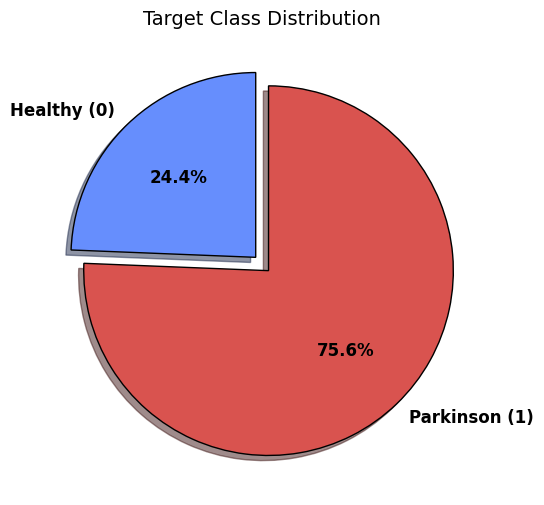

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'
labels = ['Healthy (0)', 'Parkinson (1)']
sizes = [48, 149]
colors = ['#668EFD', '#d9534f']
explode = (0.05, 0.05)
plt.figure(figsize=(6,6))
plt.pie(
    sizes, labels=labels, colors=colors,
    autopct='%1.1f%%', startangle=90,
    explode=explode, shadow=True,
    wedgeprops={'edgecolor':'black'},
    textprops={'fontsize':12, 'fontweight':'bold'})
plt.title('Target Class Distribution', fontsize=14)
plt.show()


In [29]:
x=data.drop(columns=['name','status'])
y=data['status']

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  RPDE              195 non-null    float64
 1

In [ ]:
def outlier_ratio_df(x):
  ratio=[]
  for i in x.columns:
    Q3=x[i].quantile(0.75)
    Q1=x[i].quantile(0.25)
    IQR=Q3-Q1
    Upper=Q3+1.5*IQR
    Lower=Q1-1.5*IQR
    ratio.append(len(x[(x[i]<Lower)|(x[i]>Upper)])/len(x))
  outlier = pd.DataFrame({'Outlier_Ratio': ratio}, index=x.columns)
  return outlier

In [ ]:
outlier_ratio_df(x)[outlier_ratio_df(x)['Outlier_Ratio']>=0.05].sort_values(by='Outlier_Ratio',ascending=False)

#NHR 이상치 유의

,Outlier_Ratio
NHR,0.097436
MDVP:PPQ,0.076923
Jitter:DDP,0.071795
MDVP:RAP,0.071795
MDVP:Jitter(%),0.071795
Shimmer:APQ5,0.066667
MDVP:APQ,0.061538
MDVP:Fhi(Hz),0.056410
MDVP:Shimmer(dB),0.051282


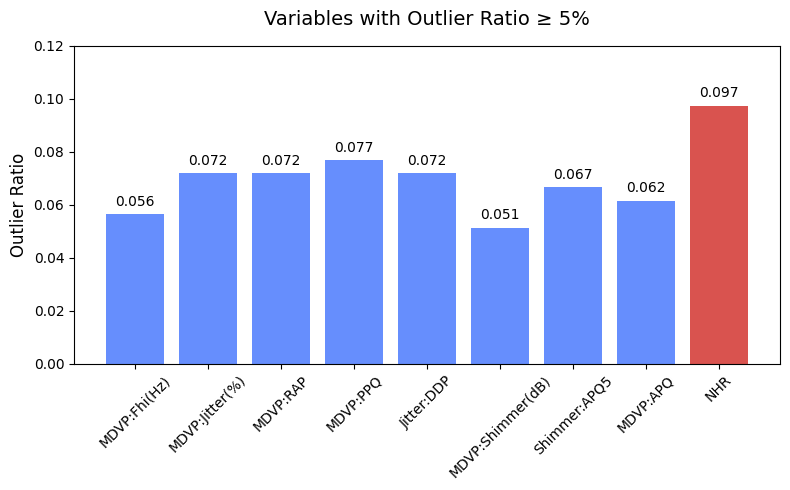

In [ ]:
outliers = outlier_ratio_df(x)
outliers_filtered = outliers[outliers['Outlier_Ratio'] >= 0.05]

plt.figure(figsize=(8,5))

default_color = '#668efd'
highlight_color = '#d9534f'

max_idx = outliers_filtered['Outlier_Ratio'].idxmax()
max_val = outliers_filtered.loc[max_idx, 'Outlier_Ratio']

bars = plt.bar(
    range(len(outliers_filtered)),
    outliers_filtered['Outlier_Ratio'],
    color=[highlight_color if i==max_idx else default_color for i in outliers_filtered.index])

plt.ylim(0, 0.12)
plt.ylabel('Outlier Ratio', fontsize=12)
plt.title('Variables with Outlier Ratio ≥ 5%', fontsize=14, pad=15)

plt.xticks(
    range(len(outliers_filtered)),
    outliers_filtered.index,
    rotation=45, ha='center', fontsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.002,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy import stats

normality_list = []

for i in x.columns:
  s,p=stats.shapiro(x[i])
  n_dict={'변수명':i,'P-Value':np.round(p,3),'정규성 여부': '채택' if np.round(p,3)>=0.05 else '기각'}
  normality_list.append(n_dict)

normality = pd.DataFrame(normality_list)

normality.sort_values(by='정규성 여부',ascending=False)

# StandardScaler 부적합

,변수명,P-Value,정규성 여부
19,spread2,0.654,채택
0,MDVP:Fo(Hz),0.000,기각
1,MDVP:Fhi(Hz),0.000,기각
20,D2,0.043,기각
18,spread1,0.026,기각
17,DFA,0.014,기각
16,RPDE,0.001,기각
15,HNR,0.001,기각
14,NHR,0.000,기각
13,Shimmer:DDA,0.000,기각


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline

robust_col=[i for i in x.columns if i not in ['spread2']]

scaler=ColumnTransformer([('Standard',StandardScaler(),['spread2']),('Robust',RobustScaler(),robust_col)])

pipeline=Pipeline([('scaling',scaler)])

In [ ]:
pipeline.fit(x_train)

x_train_scaled=pipeline.transform(x_train)

x_test_scaled=pipeline.transform(x_test)

ML:RandomForest

In [ ]:
#1
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate,StratifiedKFold

rf=RandomForestClassifier(class_weight='balanced',random_state=42) # 클래스 불균형 대응

splitter=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

score=cross_validate(rf,x_train_scaled,y_train,cv=splitter,return_train_score=True,scoring='f1',n_jobs=-1)

np.mean(score['train_score']),np.mean(score['test_score'])


(np.float64(1.0), np.float64(0.9297372482589873))

In [ ]:
from sklearn.metrics import classification_report

rf.fit(x_train_scaled,y_train)

print(classification_report(y_test,rf.predict(x_test_scaled)))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.92      0.97      0.95        37

    accuracy                           0.92        49
   macro avg       0.91      0.86      0.88        49
weighted avg       0.92      0.92      0.92        49



In [ ]:
#2
from sklearn.model_selection import GridSearchCV

rf=RandomForestClassifier(class_weight='balanced',random_state=42)

parameter = {'n_estimators': [300, 500],'max_depth': [4,6,8,10],'min_samples_split': [4,6,8,10],'min_samples_leaf': [2,4,6],'max_features': ['sqrt', 0.6]}

grid=GridSearchCV(rf,parameter, cv=splitter,scoring='f1',return_train_score=True,n_jobs=-1)

grid.fit(x_train_scaled,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'max_features': ['sqrt', 0.6],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [4, 6, 8, 10],
                         'n_estimators': [300, 500]},
             return_train_score=True, scoring='f1')

In [ ]:
best_index = grid.best_index_

best_train = grid.cv_results_['mean_train_score'][best_index]
best_test  = grid.cv_results_['mean_test_score'][best_index]

print("best train:", best_train)
print("best test :", best_test)
print("gap:", best_train - best_test)

best train: 1.0
best test : 0.9370271033314511
gap: 0.06297289666854888


In [ ]:
grid.best_params_

{'max_depth': 6,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 300}

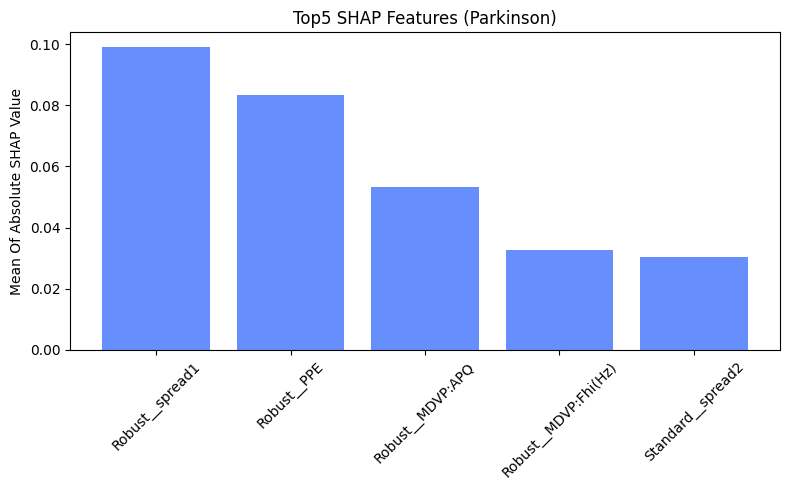

In [ ]:
scaler = pipeline.named_steps['scaling']

try:
    feature_names = scaler.get_feature_names_out()
except:
    feature_names = x_train.columns
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=feature_names)

import shap

best_rf = grid.best_estimator_
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(x_train_scaled_df)
shap_values_class1 = shap_values[:, :, 1]

mean_shap = np.abs(shap_values_class1).mean(axis=0)
sorted_idx = np.argsort(mean_shap)[::-1]

top_idx = sorted_idx[:5]
top_features = x_train_scaled_df.columns[top_idx]
top_values = mean_shap[top_idx]

x_pos = np.arange(len(top_features))

plt.figure(figsize=(8,5))
plt.bar(x_pos,top_values,color="#668efd")
plt.xticks(x_pos, top_features, rotation=45, ha='center')
plt.ylabel("Mean Of Absolute SHAP Value")
plt.title("Top5 SHAP Features (Parkinson)")
plt.tight_layout()
plt.show()

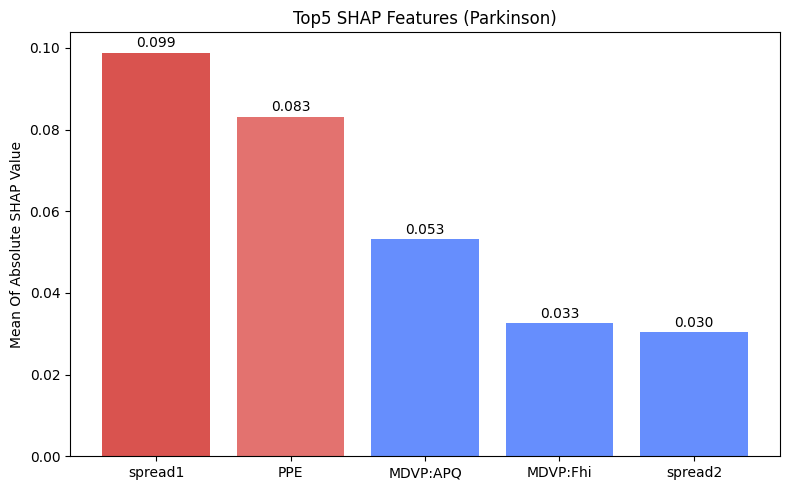

In [ ]:
top_idx = sorted_idx[:5]
top_values = mean_shap[top_idx]

x_labels = ['spread1', 'PPE', 'MDVP:APQ', 'MDVP:Fhi', 'spread2']
x_pos = np.arange(len(top_values))

colors = ['#d9534f', '#e3726f', '#668efd', '#668efd', '#668efd']

plt.figure(figsize=(8,5))
bars = plt.bar(x_pos, top_values, color=colors)

plt.xticks(x_pos, x_labels, ha='center')
plt.ylabel("Mean Of Absolute SHAP Value")
plt.title("Top5 SHAP Features (Parkinson)")

for i, bar in enumerate(bars):
    height = top_values[i]
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.0005, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()